In [1]:
%pylab
import seaborn as sns
%load_ext autoreload
%autoreload 2
from random import choice as randsample
%matplotlib inline
import statespace as st
import pandas as pd

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


State space analysis 
====================

This notebook demonstrates how to perform a state space analysis on MEG data Mante et al style. I start by giving an example on fake data and then showing the results on Anne's MEG data. The later ones are not computed in the notebook and only the results are shown (for time/space reasons).

How does the state space analysis work?
-------------------------------------

The goal of the state space analysis is to find a representation of a high dimensional data set in a few meaningful dimensions. To find these dimensions it uses a regression model that predicts the physiological response we are interested in based on regressors (e.g. experimental conditions). The regression model is performed separately for each unit (here MEG channel) and timestep. The trick is now to combine the betas of the regression model across units such that we obtain # of time points x # conditions vectors with length # of units. This vector encodes how much each channel contributes to the activity in a specific condition. We can therefore use it to project the high dimensional activity into a 1D space that is related to a particular condition (e.g. meaningful). Do this for 2 conditions and you obtain nice plots. Along the way Mante et al. perform some cleaning of the data based on PCA.

Here comes everything I just described in a little more detail.

Step 1: Regression analysis
---------------------------

For each unit (channel/sensor/whatever) predict it's z-scored activation from a set of regressors. This gives a vector of size $N_{coef}$ for each unit and timestep, let's call this vector $\beta_{i,t}$ and $i$ indexes units and $t$ indexes time.

Step 2: PCA based population cleaning
-------------------------------------

   - For each unit construct average response vectors in all conditions.
   - z-score condition averages and smooth them 
   - Define vector $x_{c,t}$ that contains the value of all units in condition $c$ at time $t$.$x_{c,t}$ is of size $N_{units}$
   - Build matrix $X$ of size $N_{unit} x (N_{condition} * T)$, where the columns contain the concatenaed population averages. Concatenated across conditions and time that is. Run PCA on $X$ and collect the first 12 PCs in vectors $v_a$ where $a$ indexes the PCs. Each $v_a$ is of size $N_{unit}$.
   -  Project matrix $X$ onto the first 12 components. 

Step 3: Projection into regression subspace
-------------------------------------------

   - We start by rearranging the $\beta_{i,t}$'s into vectors that contain the regression weights of one condition and time point for all units: $\beta_{i,t} \rightarrow \beta_{v,t}$.
   - Now denoise these vectors using the PCA projection, this works since $\beta_{v,t}$ has size $N_{units}$.
   - Now find for each $v$ the maximum over time in each the vector $\beta_{v,t}$. Thies yields one vector $\beta_{v}^{max}$ for each $v$.
   - Construct matrix $B^{max} = [\beta_{1}^{max}, ..., \beta_{k}^{max}]$ and apply $QR$ decomposition.
   - The matrix $Q$ now contains orthogonalized $\beta_v^{Orth}$ vectors.
   - Project data matrix $X$ into orthogonal space: $p_{v,c} = \beta_v^{Orth} X_c$ and now $X_c$ only contains data from condition $c$.
   
Example One: Fake data
============

Let's look at an example dataset. Let's assume that we recorded some units (e.g. MEG channels) during a random mot discrimination task. The observers either had to discriminate based on motion coherence (-1 or 1; made up values...) or color coherence (-1 or 1). On every trial both motion and color was present and the observers were cued before the trial to which one to attend to.


In [2]:
# Simulate some data. In each trial color has a certain effect, motion, choice and context.
import fake_experiment
from ocupy import datamat
Nunits = 35
Ntrials = 155

units =  fake_experiment.make_experiment(Ntrials, Nunits)
st.zscore(units)

I will plot the averages of each unit in the different conditions now. Each line is one unit. Each panel is one condition

In [3]:
# Make a long form dataframe
from ocupy import datamat
dmlong = datamat.DatamatAccumulator()
for t in range(100):
    d = units.copy()
    d.data = d.data[:,t]
    d.add_field('time', ones(d.mc.shape)*t)
    dmlong.update(d)
dmlong = dmlong.get_dm()
df = pd.DataFrame(dict((key, dmlong.field(key)) for key in dmlong.fieldnames()))
mapping = {-1:{-1:0, 1:1}, 1:{-1:2, 1:3}}
condition = [mapping[a][b] for a,b in zip(df.mc, df.colorc)]
df['condition'] = condition
df_trials = df.copy()
df = df.groupby(['time', 'unit', 'mc', 'colorc']).mean()
mapping = {0:'MC-, CC-', 1:'MC-, CC+', 2:'MC+, CC-', 3:'MC+, CC+'}
df['condition'] = [mapping[c] for c in df.condition]


In [4]:
df = df.reset_index()

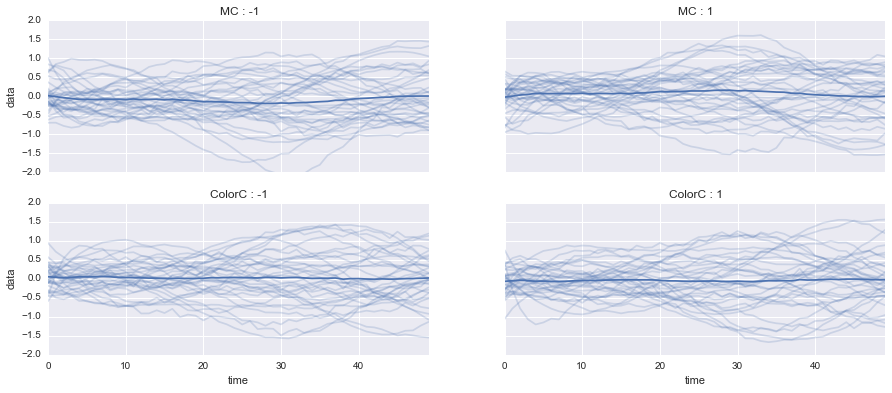

In [5]:
figure(figsize=(15,6))
from matplotlib import gridspec
gs = GridSpec(2,8)
subplot(2,2,1)
dfmc = df.groupby(['time', 'unit', 'mc']).agg(mean).reset_index()
sns.tsplot(dfmc[dfmc.mc==-1], time='time', unit='unit', value='data', err_style='unit_traces')
xlabel('')
ylim([-2,2])
gca().set_xticklabels([])
title('MC : -1')
subplot(2,2,2)
dfmc = df.groupby(['time', 'unit', 'mc']).agg(mean).reset_index()
sns.tsplot(dfmc[dfmc.mc==1], time='time', unit='unit', value='data', err_style='unit_traces')
xlabel('')
ylabel('')
ylim([-2,2])
title('MC : 1')
gca().set_xticklabels([])
gca().set_yticklabels([])

subplot(2,2,3)
dfmc = df.groupby(['time', 'unit', 'colorc']).agg(mean).reset_index()
sns.tsplot(dfmc[dfmc.colorc==-1], time='time', unit='unit', value='data', err_style='unit_traces')
ylim([-2,2]) 
title('ColorC : -1')
subplot(2,2,4)
dfmc = df.groupby(['time', 'unit', 'colorc']).agg(mean).reset_index()
sns.tsplot(dfmc[dfmc.colorc==1], time='time', unit='unit', value='data', err_style='unit_traces')
ylim([-2,2])
title('ColorC : 1')
gca().set_yticklabels([])
ylabel('')

> ** Figure 1**. *Raw timecourses of simulated data in different conditions.* Top row shows the activation of each unit averaged across color coherence when the motion coherence is -1 or 1 (Left, Right). Bottom row shows the same for color coherence. Individual units show no clear relationship to either condition. The average activation (solid lines) reveals that I constructed the units to be symmetric within individual conditions.


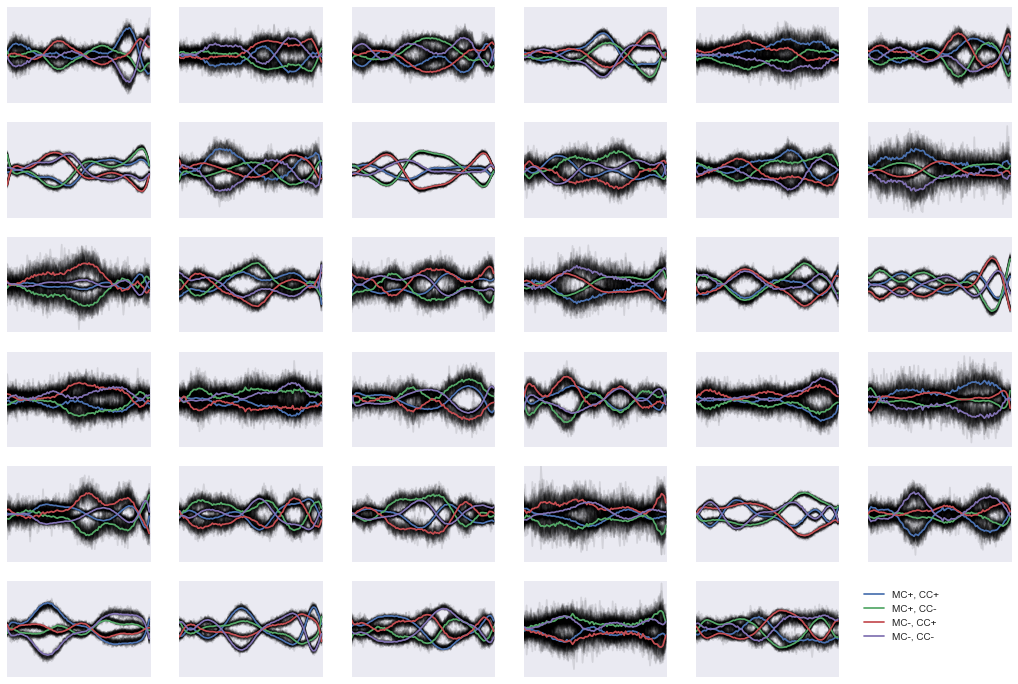

In [6]:
bnt, labels = st.patsy_regression_weights(units, 'mc + colorc + 1')
figure(figsize=(18,12))
for un in unique(units.unit):
    subplot(6,6, un+1)
    u0 = units[units.unit==un]
    u = df_trials[df_trials.unit==un]
    p = u.pivot(index='trial', columns='time', values='data')
    _=plot(u0.data.T, 'k', alpha=0.1)
    #print bnt.coef[0, 75, :]
    h0=plot(bnt.coef[un,:,2]+bnt.coef[un,:,1])[0]
    h1=plot(bnt.coef[un,:,2]-bnt.coef[un,:,1])[0]
    h2=plot(-bnt.coef[un,:,2]+bnt.coef[un,:,1])[0]
    h3=plot(-bnt.coef[un,:,2]-bnt.coef[un,:,1])[0]
    xticks([])
    yticks([])
    ylim([-5, 5])
legend([h0, h1, h2, h3], ['MC+, CC+', 'MC+, CC-', 'MC-, CC+', 'MC-, CC-'], 
       bbox_to_anchor=(1.75, 1.))

> **Figure 2.** Units show mixing of signals. Each panel is one unit in all four conditions. Black traces show individual trials, colored curves are averages. Each curve mixes signals since the average for one condition strongly depends on the value of the average condition. 

The goal of the spate space analysis is to 'demix' the responses from individual units and pool these demixed signals across units. 

Perform state space analysis
---------------------------

I've implemented the analysis in statespace.py. To do this we need to set up a few things:


In [7]:
'''
The next two variables encode which conditions we are interested in. 
They are somewhat redundant, this will be improved in the future
'''
valid_conditions = [{'mc': -1, 'colorc': -1},
                    {'mc': 1, 'colorc': -1},
                    {'mc': -1, 'colorc': 1},
                    {'mc': 1, 'colorc': 1}]
'''
We also need to define a regression model. This is done by using a 
formula language that you might know from R. What model you use is up to you.
Here we define one regressor for each condition, since they are encoded by +- 1 
this is a form of effect coding.:
'''
formula = 'mc + colorc +1'

The next step computes everything that is needed to project the data into the low dimensional state space

In [8]:
Q, Bmax, labels, bnt, D, t_bmax, norms, maps, exp_var, pca = st.embedd(
    units, formula, valid_conditions, N_components=35)

Getting regression weights
Doing PCA cleaning
Fitting PCA = 35 components
Transforming X
[  1.91286443e-01   1.61628358e-01   1.42732689e-01   1.27184756e-01
   8.66475443e-02   7.20327860e-02   4.79573833e-02   4.31097666e-02
   3.59787518e-02   2.42046720e-02   1.63121279e-02   1.42963587e-02
   9.29959622e-03   8.07384662e-03   5.68154837e-03   3.56446726e-03
   2.74660670e-03   1.70031311e-03   1.44377761e-03   1.14424872e-03
   7.56285400e-04   4.77477004e-04   4.35203659e-04   3.62813598e-04
   2.47915917e-04   2.02500485e-04   1.19712107e-04   1.08387978e-04
   7.97802739e-05   6.77618781e-05   4.01600384e-05   2.90217219e-05
   2.02820099e-05   1.67262615e-05   9.92974274e-06]
Regression embedding


The first thing to understand is how the regression works. To understand this we can look at the regression weights that were obtained for each unit, condition and time point. The top row shows three maps with regression weights for each condition, x-axis is time, y-axis shows different units. The bottom panel shows average responses and average regression weights. These are somwehat related, but .

mc
colorc


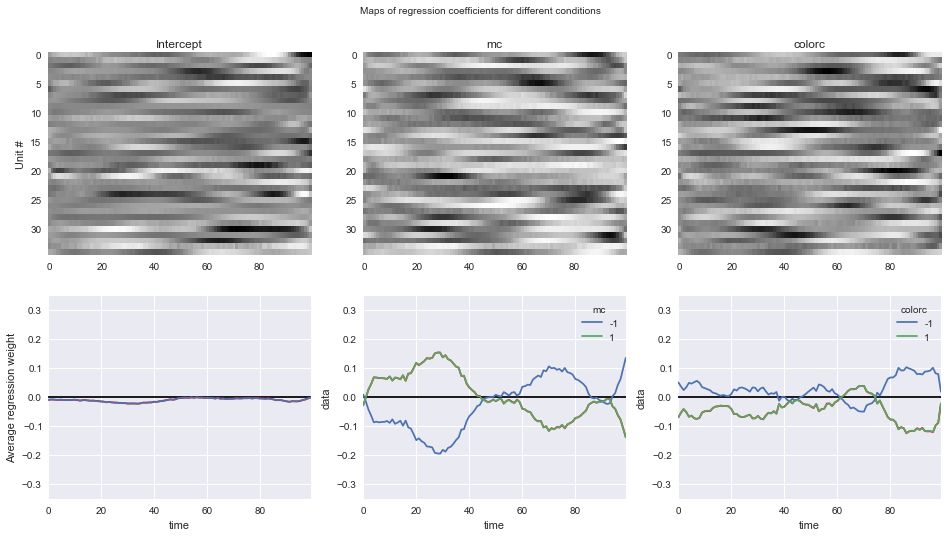

In [9]:
figure(figsize=(16, 8))
for i, m in enumerate(maps):

    subplot(2,3, i+1)
    imshow(m.T, interpolation='nearest', aspect='auto')
    if i == 0:
        ylabel('Unit #')
    title(labels[i])
    grid('off')
    subplot(2,3, i+1+3)
    if i>0:
        plot(m.mean(1)+maps[0].mean(1), 'r')
    xlabel('time')
    axhline(0, color='k')
    if i == 0:
        plot(maps[0].mean(1), 'r')
        dfmc = df.groupby(['time', 'unit']).agg(mean).reset_index()
        sns.tsplot(dfmc, time='time', unit='unit', value='data', err_style=None)
        ylabel('Average regression weight')
    else:
        # Additionally plot the average response.
        print labels[i]
        dfmc = df.groupby(['time', 'unit', labels[i]]).agg(mean).reset_index()
        sns.tsplot(dfmc, time='time', unit='unit', value='data', condition=labels[i], err_style=None)
    ylim([-0.35, 0.35])
suptitle('Maps of regression coefficients for different conditions')

> **Figure 3. ** Top: Maps of regression coefficients for different conditions. Bottom: Average regression coefficients across units and average activation across units. 


Now comes the single **most important trick** in the entire scheme: We stop looking at individual regression weigths, but only look at columns of weights and treat these as axes in a high dimensional space. This effectively defines a mapping from high dimensional space into a low one dimensional space. Lets try to visualize this. I pick out one arbitray colum of 'MC' condition.

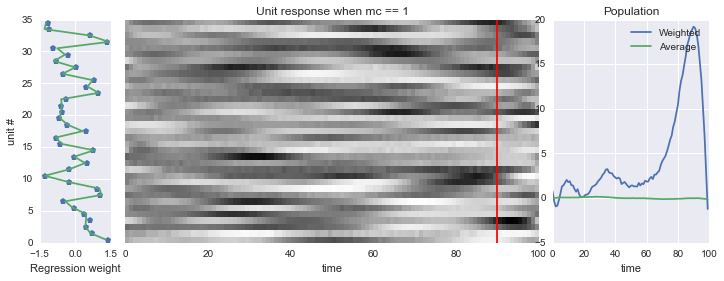

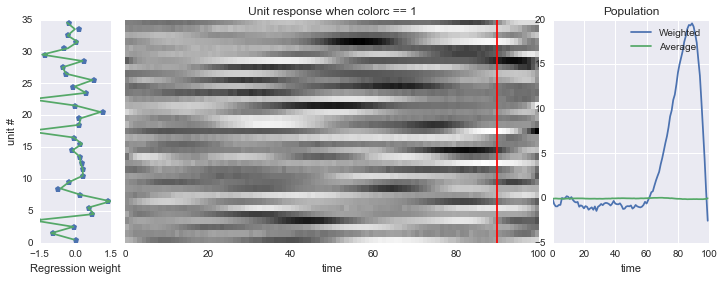

In [10]:
axes = {}
axnum = 90
for cond, mapnum in zip(['mc', 'colorc'], [1,2]):
    l = df[(df[cond]==1)].groupby(['time', 'unit', cond]).agg(mean).reset_index()
    unit_responses = l.pivot(index='unit', columns='time', values='data')

    figure(figsize=(12, 4))
    gs = GridSpec(1, 8)
    subplot(gs[:,0])
    axis = maps[mapnum][axnum, :]
    axes[cond] = axis
    ylabel('unit #')
    xlabel('Regression weight')
    xlim([-1, 1])
    xticks([-1.5, 0, 1.5])
    plot(axis, 0.5+arange(len(axis)), 'p')

    plot(unit_responses.values[:, axnum], 0.5+arange(35))
    subplot(gs[:,1:-2])
    imshow(unit_responses, interpolation='nearest', aspect='auto', extent=[0, 100, 35, 0])
    axvline(axnum, color='r')
    #axvline(t_bmax[mapnum], color='b')
    grid('off')
    title('Unit response when %s == 1'%cond)
    xlabel('time')
    _ = yticks([])
    subplot(gs[:,-2:])
    plot(dot(axis, unit_responses.values))
    plot(unit_responses.values.mean(0))
    xlabel('time')
    title('Population')
    legend(['Weighted', 'Average'])

> ** Figure 4** Treating regression coefficients as axes. Top: Motion coherence condition. The left panel shows the regression coefficient from the center panel at the red line. The blue line in the right panel shows the population activity projected (i.e. weighted) onto this axes. The green line shows the population mean without weighting. 

But which axis should you take? Each timepoint is one possible axes. Mante et al. suggest to select the axis with maximum norm. This implies that we take the longest vector which should be the one that shows maximal difference to zero. *Why L2 norm?* L2 here roughly translates into trading off how many units participates with the size of their regression weights. I.e. if we have a 2D axis where the sum of the weights is one, we'll prefer thos axes whit larger individual weights. 

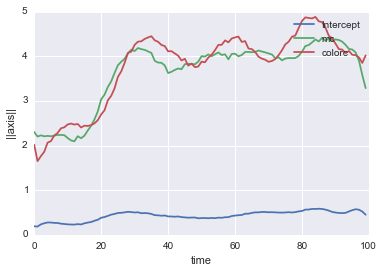

In [11]:
plot(norms[0])
plot(norms[1])
plot(norms[2])
xlabel('time')
ylabel('||axis||')
legend(labels)

> **Figure 5** Different lines show the norm of axes as a function of time.

Since these axes are not necessarily orthogonal, each activation that moves towards the encoding pattern for the color condition will also move towards the pattern for the motion coherence condition. This is not so nice to keep apart signal contributions to different conditions. We will therefore now orthogonalize all axis using QR decomposition. To understand what the QR decomposition does, let's look at a 2D example first.

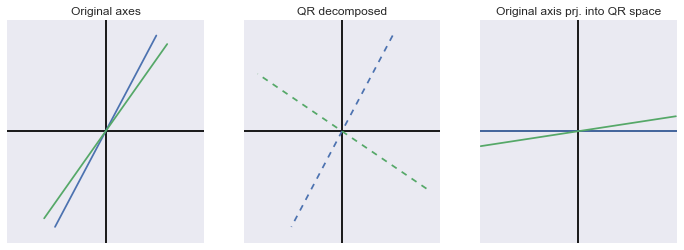

In [12]:
figure(figsize=(12,4))
def p(ax1, ax2, v1, v2, style='-'):
    '''
    Project v1 and v2 onto ax1 and ax2 and plot them.
    '''
    axhline(0, color='k')
    axvline(0, color='k')
    qp1 = [dot(ax1, v1), dot(ax2, v1)]
    qp2 = [dot(ax1, v2), dot(ax2, v2)]
    qp2 = qp2/norm(qp2)
    qp1 = qp1/norm(qp1)
    plot([-qp1[0], qp1[0]], [-qp1[1], qp1[1]], style)
    plot([-qp2[0], qp2[0]], [-qp2[1], qp2[1]], style)
    xlim([-1,1])
    ylim([-1,1])
    #print 'angle = ', rad2deg(arccos(dot(qp1, qp2)/(norm(qp1)*norm(qp2))))
    xticks([], [-1, 0, 1])
    yticks([], [-1, 0, 1])
    
p1 = array([3, 5.]) 
p2 = array([4, 5.]) 
a = array((p1, p2)).T
q,r = qr(a)
subplot(1,3,1)
title('Original axes')
p([1,0], [0,1], p1, p2)

#legend(['', '', 'P1', 'P2'])
subplot(1,3,2)
title('QR decomposed')
p([1,0], [0,1], q[:,0], q[:,1], '--')

subplot(1,3,3)
title('Original axis prj. into QR space')
p(q[:,0], q[:,1], p1, p2)


> **Fiugre 6** shows the effect of orthogonalizing axes in 2D. Left panel shows two vectors that we want to orthogonalize. Center panel shows the orthogonalized vectors. *Note how the blue vector has not changed it's orientation.* This has important consequences for the interpretation of axes: Since only the green axis moves it only captures the part of the signal that is not correlated to blue. In the presence of correlated axes, QR orthogonalization assigns as much variance as possible to the first and whatever remains to the second. The right panels shows what happends when we project the original axes into the QR-orthogonalized space.

The state space embedding carries out the orthogonalization for us and saves the orthogonal axes in matrix Q. It contains the orthogonalized dimension vectors that you can use to embed your signal into the lower dimensional space. The dimensionality is: #num units x #num conditions. The labels vector gives the ordering. Let's look at 1D state space trajectories. That is, **let's compute condition averages and project them into the low dimensional state space**.

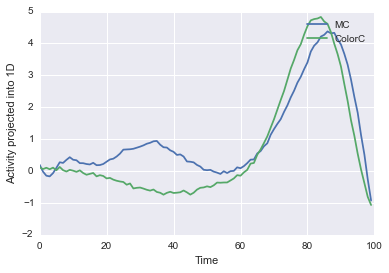

In [16]:
for i, cond in zip([1,2], ['mc', 'colorc']):
    l = df[(df[cond]==1)].groupby(['time', 'unit', cond]).agg(mean).reset_index()
    unit_responses = l.pivot(index='unit', columns='time', values='data')
    plot(dot(Q[:,i], unit_responses))
legend(['MC', 'ColorC'])
xlabel('Time')
ylabel('Activity projected into 1D')

> **Figure 7**. 1D state space trajectories for MC=1 and ColorC=1. The trajectories are obtained by projecting the population average in a condition into the subspace defined by each of the two axes.

Now we can compute the trjaectories in state space during the conditions we are interested. We therefore project the average response to our conditions into the lower dimensional state space.

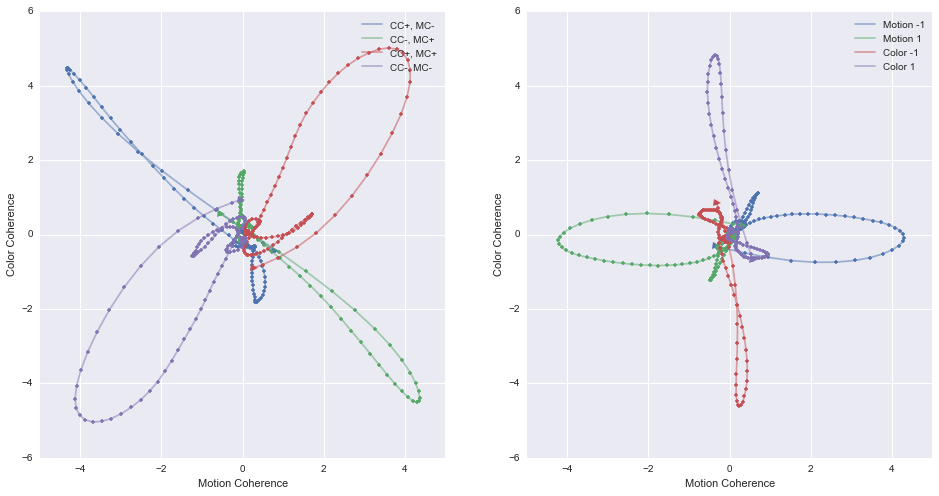

In [25]:
figure(figsize=(16, 8))
subplot(1,2,1)
colors = sns.color_palette()
results = st.get_trajectory(units, valid_conditions, Q[:, 1], Q[:, 2])
leg = []
for i, (condition, trajectory) in enumerate(results.iteritems()):
    mc, colorc, time = trajectory
    leg.append(plot(mc, colorc, color=colors[i], alpha=0.5)[0])
    plot(mc, colorc,'.',  color=colors[i])
    plot(mc[0], colorc[0], color=colors[i], marker='s')
    plot(mc[-1], colorc[-1], color=colors[i], marker='>')
xlabel('Motion Coherence')
ylabel('Color Coherence')
legend(leg, ['CC+, MC-', 'CC-, MC+', 'CC+, MC+', 'CC-, MC-'])

subplot(1,2,2)
results = st.get_trajectory(units, st.dict_product({'mc':[-1,1]}), Q[:, 1], Q[:, 2])
leg = []
for i, (condition, trajectory) in enumerate(results.iteritems()):
    mc, colorc, time = trajectory
    leg.append(plot(mc, colorc, color=colors[i], alpha=0.5)[0])
    plot(mc, colorc, '.', color=colors[i])

    plot(mc[0], colorc[0], color=colors[i], marker='s')
    plot(mc[-1], colorc[-1], color=colors[i], marker='>')
xlabel('Motion Coherence')
ylabel('Color Coherence')

results = st.get_trajectory(units, st.dict_product({'colorc':[-1,1]}), Q[:, 1], Q[:, 2])
for i, (condition, trajectory) in enumerate(results.iteritems()):
    mc, colorc, time = trajectory
    leg.append(plot(mc, colorc, color=colors[i+2], alpha=0.5)[0])
    plot(mc, colorc, '.', color=colors[i+2])
    plot(mc[0], colorc[0], color=colors[i+2], marker='s')
    plot(mc[-1], colorc[-1], color=colors[i+2], marker='>')
xlabel('Motion Coherence')
ylabel('Color Coherence')
legend(leg, ['Motion -1', 'Motion 1', 'Color -1', 'Color 1'])

> **Figure 8.** State space representation of the data. Squares mark the start point, triangles mark the end point of the trajectories. The plot on the left shows the four condition for each combination of conditions, while the plot on the left shows the motion and color coherence condition averaged across the respective other condition.

PCA cleaning - which I have ommited so far.
-----------------------------------------

Mante et al. use a PCA to remove noise from their data set. With the smooth synthetic data this is not really necessary, but let's cover it anyway.  

Mante et al's approach is to compute a PCA where each time point in each condition enters the PCA separately. The units are the features such that each principal component has if dimensionality #num_units. *The PCs express the patterns of change across units that capture most of the variance in the data.*  

The next step is to project the regression vectors (a.k.a axis) into the space defined by the PCA and then to keep working with these 'denoised' vectors. 
 
Let's see what this looks like:

In [87]:
Qpca, Bmaxpca, labelspca, bntpca, Dpca, t_bmaxpca, normspca, mapspca, exp_varpca, pca = st.embedd(units, formula, valid_conditions, N_components=12)

Getting regression weights
Doing PCA cleaning
Fitting PCA = 12 components
(400, 35)
Transforming X
[ 0.19128644  0.16162836  0.14273269  0.12718476  0.08664754  0.07203279
  0.04795738  0.04310977  0.03597875  0.02420467  0.01631213  0.01429636]
Regression embedding


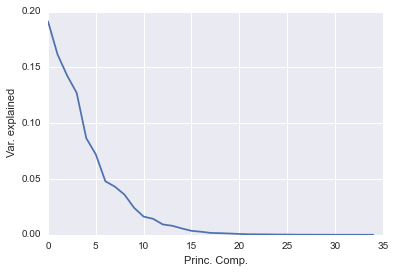

In [88]:
plot(exp_var)
ylabel('Var. explained')
xlabel('Princ. Comp.')

> **Figure 9.** Variance explained by each principal component in the data.

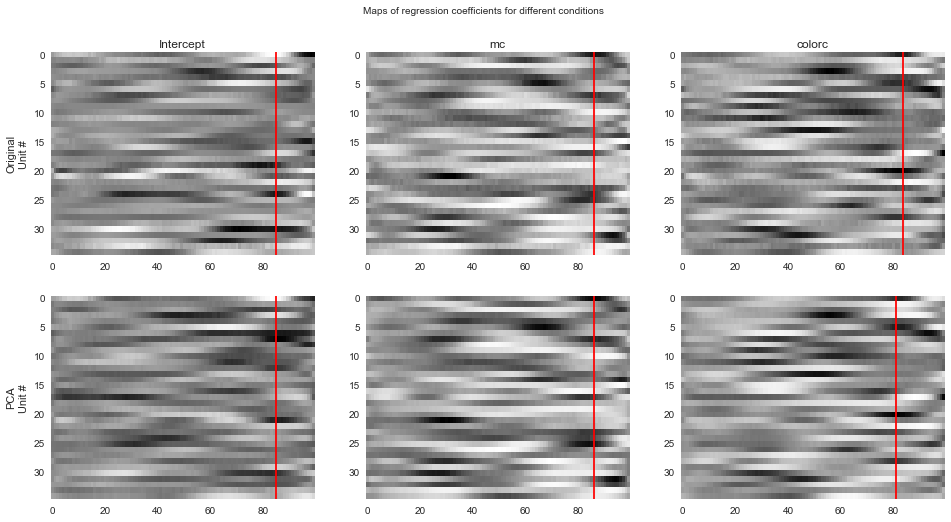

In [89]:
figure(figsize=(16, 8))
for i, (m, mpca) in enumerate(zip(maps, mapspca)):

    subplot(2,3, i+1)
    imshow(m.T, interpolation='nearest', aspect='auto')
    axvline(t_bmax[i], color='r')
    if i == 0:
        ylabel('Original\nUnit #')
    title(labels[i])
    grid('off')
    subplot(2,3, i+1+3)
    imshow(mpca.T, interpolation='nearest', aspect='auto')
    axvline(t_bmaxpca[i], color='r')

    grid('off')
    if i == 0:
        ylabel('PCA\nUnit #')
suptitle('Maps of regression coefficients for different conditions')

> **Figure 10. ** Top: Maps of regression coefficients for different conditions without PCA cleaning. Bottom: Maps of regression coefficients with PCA cleaning. Red lines show maximum norm axes. 


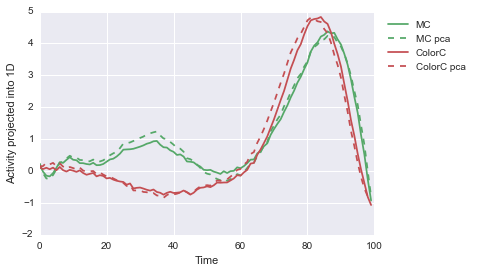

In [90]:
colors = sns.color_palette()
for i, cond in zip([1,2], ['mc', 'colorc']):
    l = df[(df[cond]==1)].groupby(['time', 'unit', cond]).agg(mean).reset_index()
    unit_responses = l.pivot(index='unit', columns='time', values='data')
    plot(dot(Q[:,i], unit_responses), color=colors[i])
    plot(dot(Qpca[:,i], unit_responses), '--', color=colors[i])
legend(['MC', 'MC pca',  'ColorC', 'ColorC pca'], bbox_to_anchor=(1.3, 1))
xlabel('Time')
ylabel('Activity projected into 1D')

> **Figure 11.** A comparison of 1D state space trajectories with (--) and without (-) PCA.  

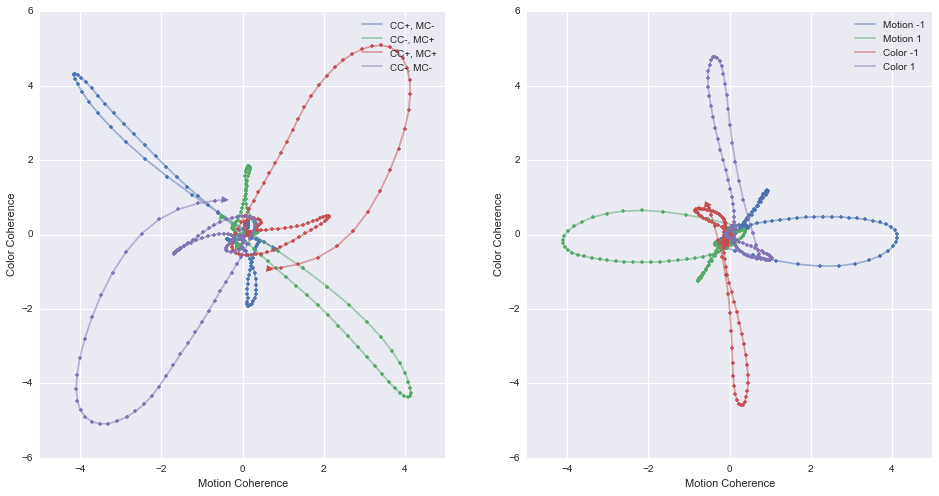

In [91]:
figure(figsize=(16, 8))
subplot(1,2,1)
colors = sns.color_palette()
results = st.get_trajectory(units, valid_conditions, Qpca[:, 1], Qpca[:, 2])
leg = []
for i, (condition, trajectory) in enumerate(results.iteritems()):
    mc, colorc, time = trajectory
    leg.append(plot(mc, colorc, color=colors[i], alpha=0.5)[0])
    plot(mc, colorc,'.',  color=colors[i])
    plot(mc[0], colorc[0], color=colors[i], marker='s')
    plot(mc[-1], colorc[-1], color=colors[i], marker='>')
xlabel('Motion Coherence')
ylabel('Color Coherence')
legend(leg, ['CC+, MC-', 'CC-, MC+', 'CC+, MC+', 'CC-, MC-'])

subplot(1,2,2)
results = st.get_trajectory(units, st.dict_product({'mc':[-1,1]}), Qpca[:, 1], Qpca[:, 2])
leg = []
for i, (condition, trajectory) in enumerate(results.iteritems()):
    mc, colorc, time = trajectory
    leg.append(plot(mc, colorc, color=colors[i], alpha=0.5)[0])
    plot(mc, colorc, '.', color=colors[i])

    plot(mc[0], colorc[0], color=colors[i], marker='s')
    plot(mc[-1], colorc[-1], color=colors[i], marker='>')
xlabel('Motion Coherence')
ylabel('Color Coherence')

results = st.get_trajectory(units, st.dict_product({'colorc':[-1,1]}), Qpca[:, 1], Qpca[:, 2])
for i, (condition, trajectory) in enumerate(results.iteritems()):
    mc, colorc, time = trajectory
    leg.append(plot(mc, colorc, color=colors[i+2], alpha=0.5)[0])
    plot(mc, colorc, '.', color=colors[i+2])
    plot(mc[0], colorc[0], color=colors[i+2], marker='s')
    plot(mc[-1], colorc[-1], color=colors[i+2], marker='>')
xlabel('Motion Coherence')
ylabel('Color Coherence')
legend(leg, ['Motion -1', 'Motion 1', 'Color -1', 'Color 1'])

> **Figure 12.** State space representation of the data with PCA cleaning. Drawing conventions from Figure 8 above.